#### ADI            : Veli 
#### SOYADI         : TÜÇ
#### Okul Numarası  : 200223013
#### DERS           : Büyük Veri Analizi

#### Age:           Bir kadının hamile kaldığı herhangi bir yaş.
#### SystolicBP:    Kan Basıncının mmHg cinsinden üst değeri, hamilelik sırasında bir diğer önemli özelliktir.
#### DiastolicBP:   Kan Basıncının mmHg cinsinden düşük değeri, hamilelik sırasında bir diğer önemli özelliktir.
#### BS:            Kan glikoz seviyeleri molar konsantrasyon cinsindendir
#### BodyTemp:      Vücut Sıcaklığı 
#### HeartRate:     Normal bir dinlenme kalp atış hızı
#### RiskLevel:     Önceki özellik dikkate alınarak gebelik sırasında öngörülen Risk Yoğunluğu Düzeyi.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
np.set_printoptions(suppress=True)

In [2]:
data = pd.read_csv('data.csv')
data.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk


In [3]:
data.isna().sum()

Age            0
SystolicBP     0
DiastolicBP    0
BS             0
BodyTemp       0
HeartRate      0
RiskLevel      0
dtype: int64

In [4]:
data["RiskLevel"].value_counts()

RiskLevel
low risk     406
mid risk     336
high risk    272
Name: count, dtype: int64

In [5]:
data["RiskLevel"].replace({"low risk": 1, "mid risk": 2, "high risk": 3}, inplace=True)
data["RiskLevel"].value_counts()

RiskLevel
1    406
2    336
3    272
Name: count, dtype: int64

In [6]:
data["RiskLevel"] = data["RiskLevel"].astype('category')

In [7]:
data["Age"].describe()

count    1014.000000
mean       29.871795
std        13.474386
min        10.000000
25%        19.000000
50%        26.000000
75%        39.000000
max        70.000000
Name: Age, dtype: float64

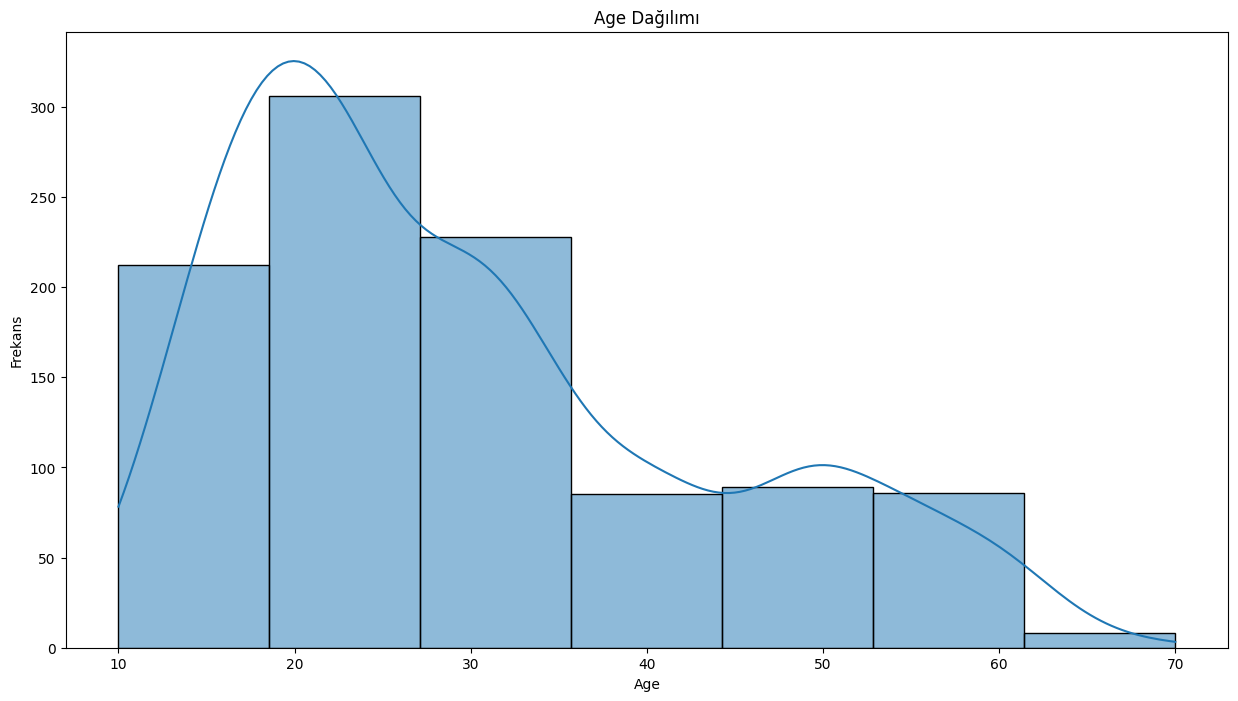

In [8]:
# burada ilk olarak verimizde ki age değişkenimizin histogramını ve dağılım grafiğini çizdirelim
plt.figure(figsize=(15,8))
sns.histplot(data['Age'], bins=7, kde=True)
plt.xlabel('Age')
plt.ylabel('Frekans')
plt.title('Age Dağılımı')
plt.show()

Burada yaş değişkenimizi incelediğimizde 23 yaşında doğum oranı en yüksek ve bunula birlikte Çocuk yaştaki gebelerle olmakla birlikte 50 yaş üstü gebelerde bulunmaktadır.
burada kendime ilk sorduğum soru yaşın riske bir etkisi var mı bir bakalım 

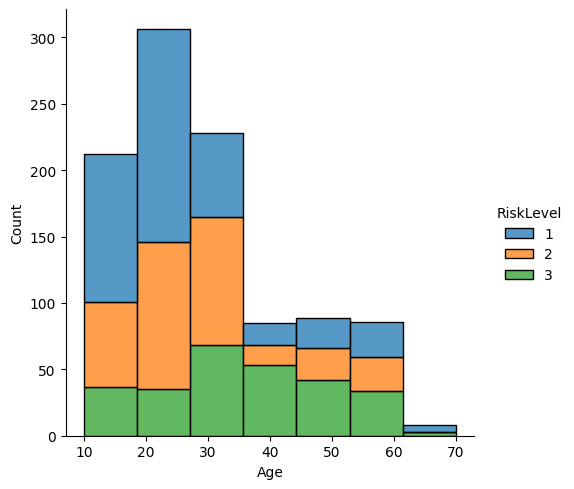

In [9]:
sns.displot(data=data, x="Age", hue="RiskLevel", bins=7, multiple="stack")

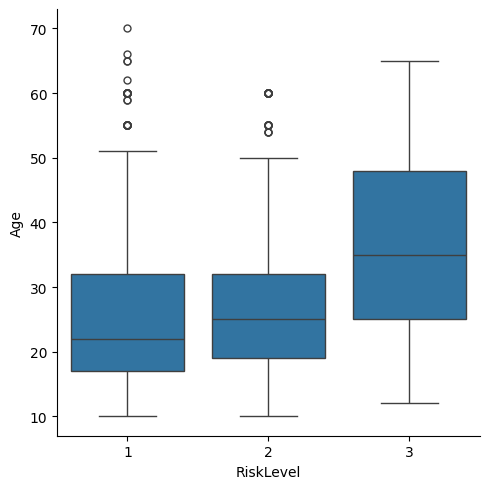

In [10]:
sns.catplot(data=data, x="RiskLevel", y="Age", kind="box")

In [11]:
def controlAssumptions(feature, data):
    from scipy.stats import shapiro
    from scipy.stats import levene
    durum = False
    dataType = data[feature].dtypes
    if dataType == 'int64' or dataType == 'float64':
        # burada sayısal verilerimiz için normmallik testi(shapiro-wilk) yapıyoruz
        stat, p = shapiro(data[feature])
        if p > 0.05:
            durum = True
        else:
            durum = False
    else:
        # burada kategorik verilerimizin homojenliğini test ediyoruz
        gruplar = data[feature].unique()
        grupListesi = []
        for grup in gruplar:
            grupListesi.append(data[data[feature] == grup]['Age'])
        stat, p = levene(*grupListesi)
        if p > 0.05:
            durum = True
        else:
            durum = False
    return durum

In [12]:
def test(data, numericalData, categoricalData):
    from scipy.stats import f_oneway
    anova = False
    hypothesis = False
    
    normality = controlAssumptions(feature=numericalData, data=data)
    homogeneity = controlAssumptions(feature=categoricalData, data=data)
    
    if normality == True:
        if homogeneity == True:
            # ANOVA-Test
            anova = True
            
            f, p = f_oneway(data[data[categoricalData] == 0][numericalData],
                            data[data[categoricalData] == 1][numericalData],
                            data[data[categoricalData] == 2][numericalData])
            if p > 0.05:
                hypothesis = True
            else:
                hypothesis = False
        else:
            # Welch-Test
            from scipy.stats import ttest_ind
            f, p = ttest_ind(data[data[categoricalData] == 0][numericalData],
                            data[data[categoricalData] == 1][numericalData],
                            data[data[categoricalData] == 2][numericalData],
                            equal_var=False)
            if p > 0.05:
                hypothesis = True
            else:
                hypothesis = False
    else:
        if homogeneity == True:
            anova = True
            f, p = f_oneway(data[data[categoricalData] == 0][numericalData],
                            data[data[categoricalData] == 1][numericalData],
                            data[data[categoricalData] == 2][numericalData])
            if p > 0.05:
                hypothesis = True
            else:
                hypothesis = False
                
    return anova, hypothesis

In [13]:
def relationTests(data, numericalData,categoricalData):
    hipotez, anova = test(data = data, numericalData = numericalData, categoricalData = categoricalData)
    result = False
    if anova == True:
        if hipotez == False:
            # burada Tukey testi yapıyoruz
            from statsmodels.stats.multicomp import pairwise_tukeyhsd
            tukey = pairwise_tukeyhsd(endog=data[numericalData], groups=data[categoricalData], alpha=0.05)
            if tukey.pvalues[0] > 0.05:
                result = False
            else:
                result = True
    else:
        if hipotez == False:
            # burada mannwhitneyu testi yapıyoruz
            from scipy.stats import mannwhitneyu
            stat, p = mannwhitneyu(data[numericalData], data[categoricalData])
            if p > 0.05:
                result = False
            else:
                result = True
    
    return result

In [14]:
relationTests(data, "Age", "RiskLevel")

c:\Users\Diablo\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_stats_py.py:4133: DegenerateDataWarning: at least one input has length 0
  warnings.warn(stats.DegenerateDataWarning('at least one input '


False

In [15]:
data["SystolicBP"].describe()

count    1014.000000
mean      113.198225
std        18.403913
min        70.000000
25%       100.000000
50%       120.000000
75%       120.000000
max       160.000000
Name: SystolicBP, dtype: float64

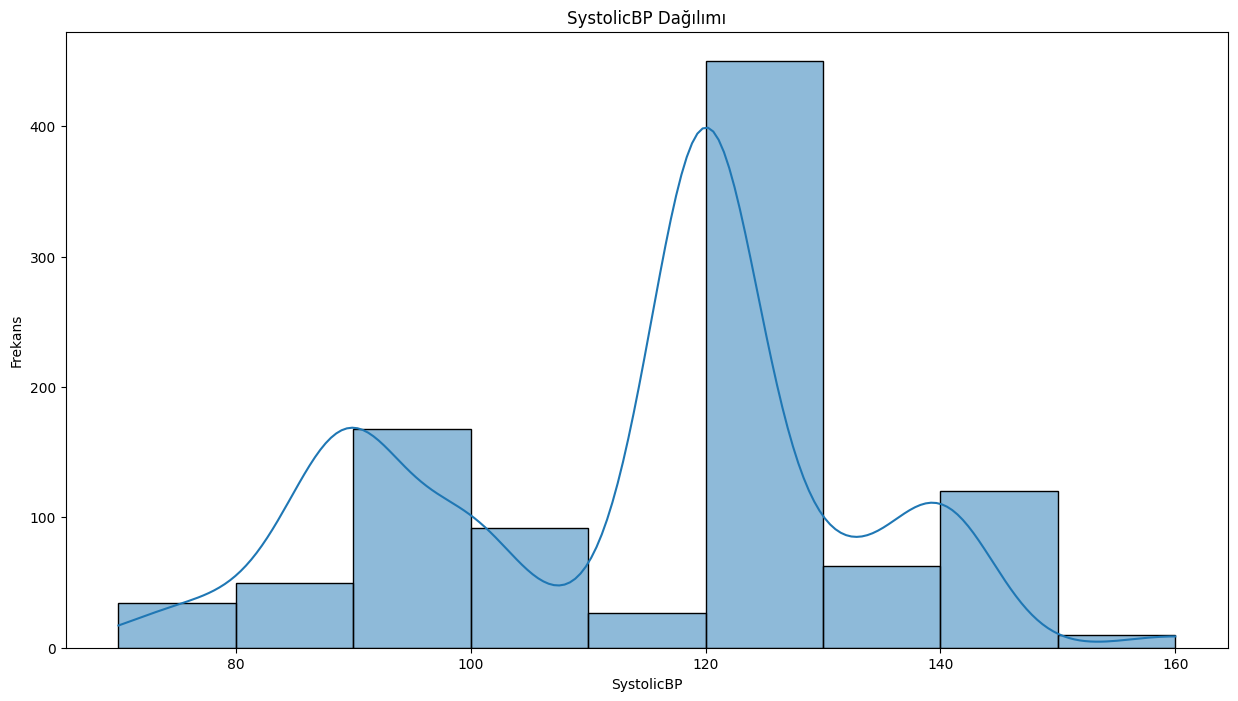

In [16]:
# SYstolicBP verimize bir grafiğe dökelim nasıl bir şey olduğunu görelim
plt.figure(figsize=(15,8))
sns.histplot(data['SystolicBP'], bins=9, kde=True)
plt.xlabel('SystolicBP')
plt.ylabel('Frekans')
plt.title('SystolicBP Dağılımı')
plt.show()

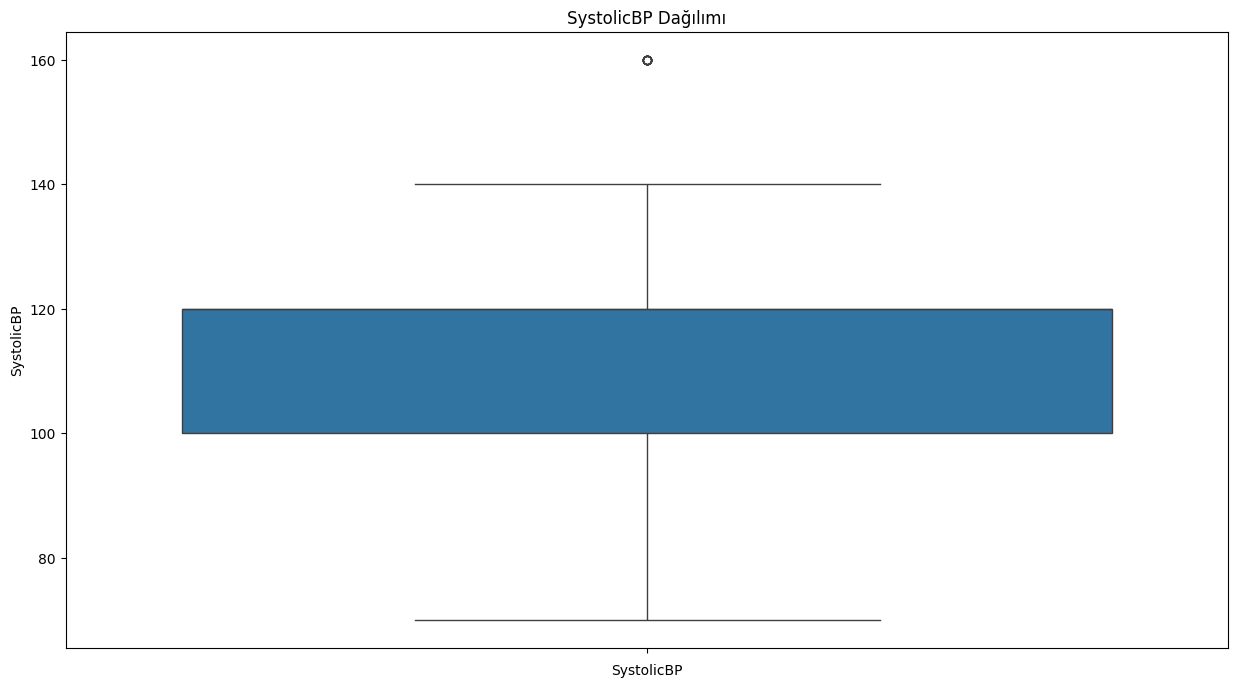

In [17]:
# burada da SystolicBP değişkenimizin boxplotını çizdirelim
plt.figure(figsize=(15,8))
sns.boxplot(y=data["SystolicBP"])
plt.xlabel('SystolicBP')
plt.title('SystolicBP Dağılımı')
plt.show()


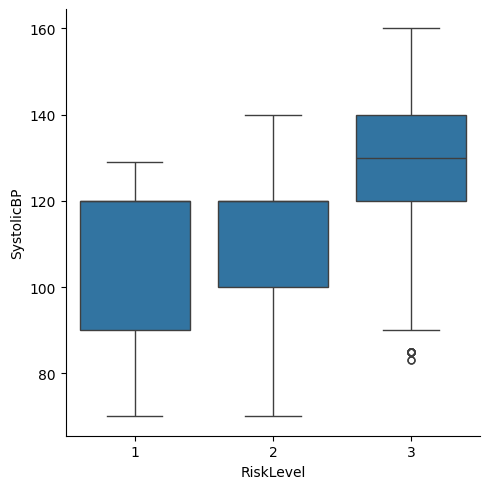

In [18]:
sns.catplot(data=data, x="RiskLevel", y="SystolicBP", kind="box")

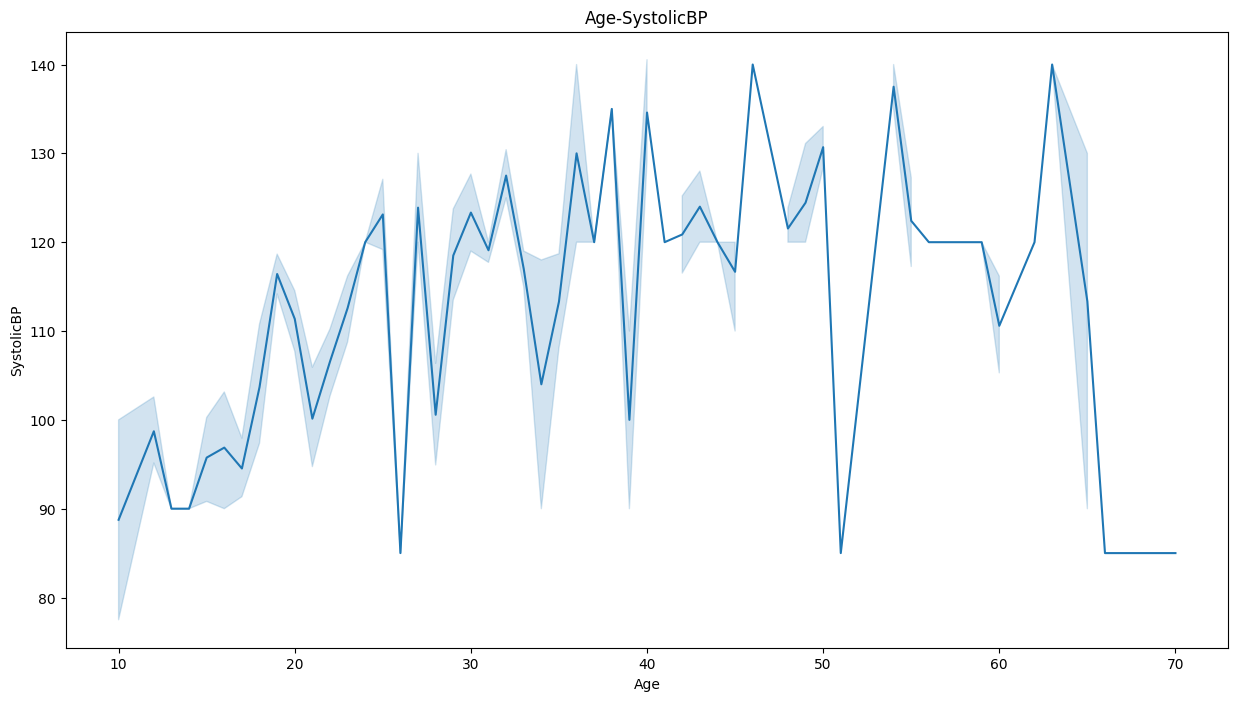

In [19]:
# SystolicBP'nin yaşa göre grafiğini çizdirelim
plt.figure(figsize=(15,8))
sns.lineplot(data=data, x="Age", y="SystolicBP")
plt.xlabel('Age')
plt.ylabel('SystolicBP')
plt.title('Age-SystolicBP')
plt.show()

In [20]:
# burada SystolicBP'nin kalp hızına bir etkisi olup olmadığını test edelim
from scipy.stats import pearsonr

corr, p = pearsonr(data['DiastolicBP'], data['HeartRate'])

print(corr, p)

if p <= 0.05:
    print("İlişki vardır (H0 reddedilir)")
else: 
    print("İlişki yoktur (H0 reddedilemez)")

-0.04615057091697696 0.14195233069036556
İlişki yoktur (H0 reddedilemez)


In [21]:
relationTests(data=data, numericalData="SystolicBP", categoricalData="RiskLevel")

c:\Users\Diablo\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_stats_py.py:4133: DegenerateDataWarning: at least one input has length 0
  warnings.warn(stats.DegenerateDataWarning('at least one input '


False

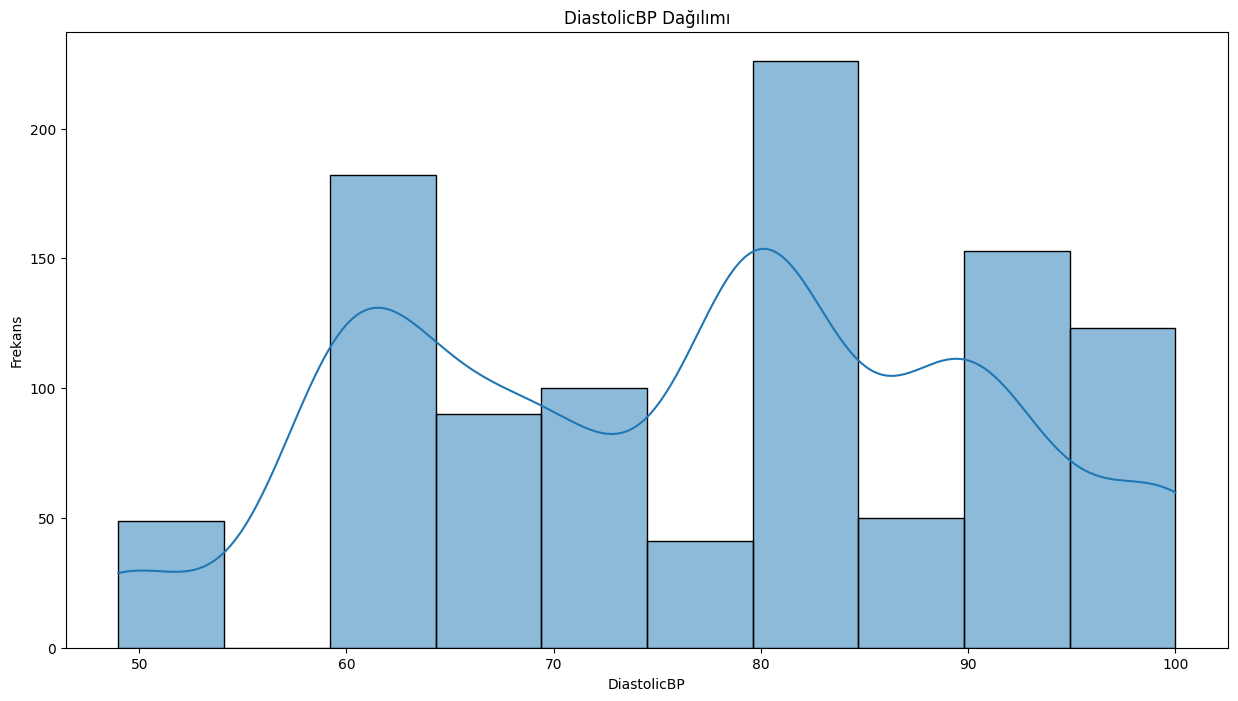

In [22]:
# DiastolicBP verimize bir grafiğe dökelim nasıl bir şey olduğunu görelim
plt.figure(figsize=(15,8))
sns.histplot(data['DiastolicBP'], bins=10, kde=True)
plt.xlabel('DiastolicBP')
plt.ylabel('Frekans')
plt.title('DiastolicBP Dağılımı')
plt.show()

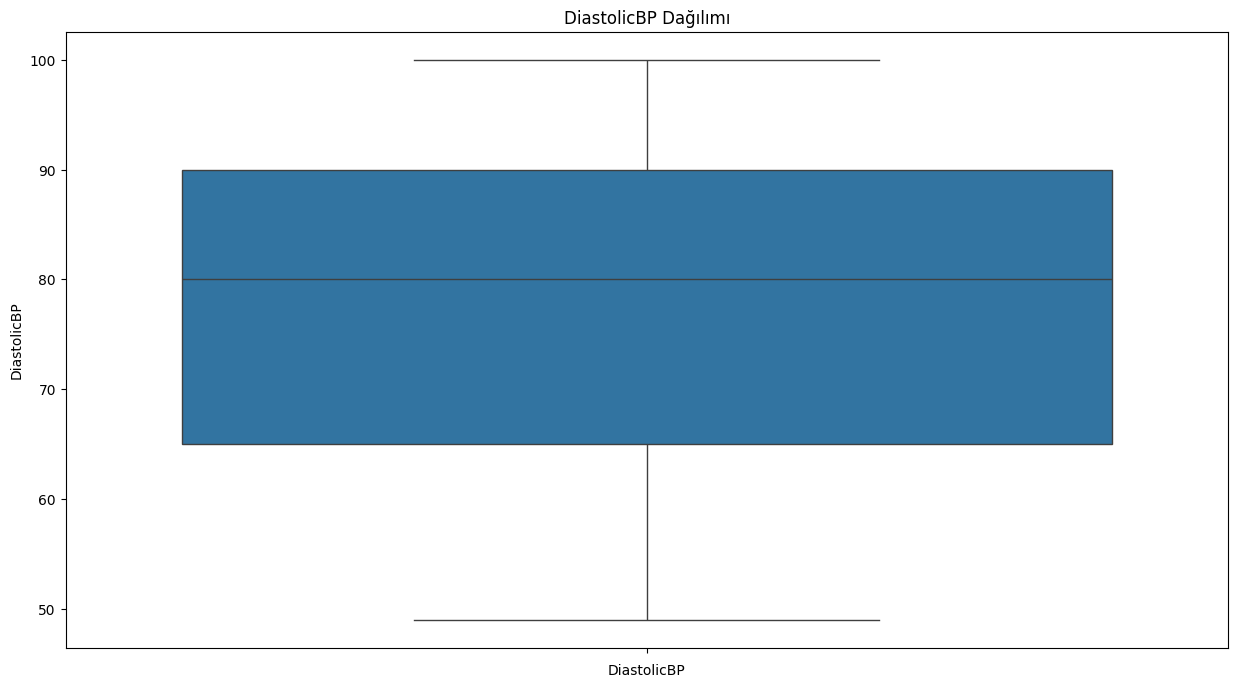

In [23]:
# burada da DiastolicBP değişkenimizin boxplotını çizdirelim
plt.figure(figsize=(15,8))
sns.boxplot(y=data["DiastolicBP"])
plt.xlabel('DiastolicBP')
plt.title('DiastolicBP Dağılımı')
plt.show()


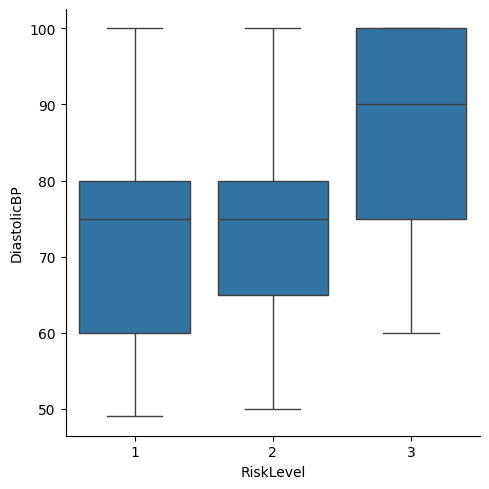

In [24]:
sns.catplot(data=data, x="RiskLevel", y="DiastolicBP", kind="box")

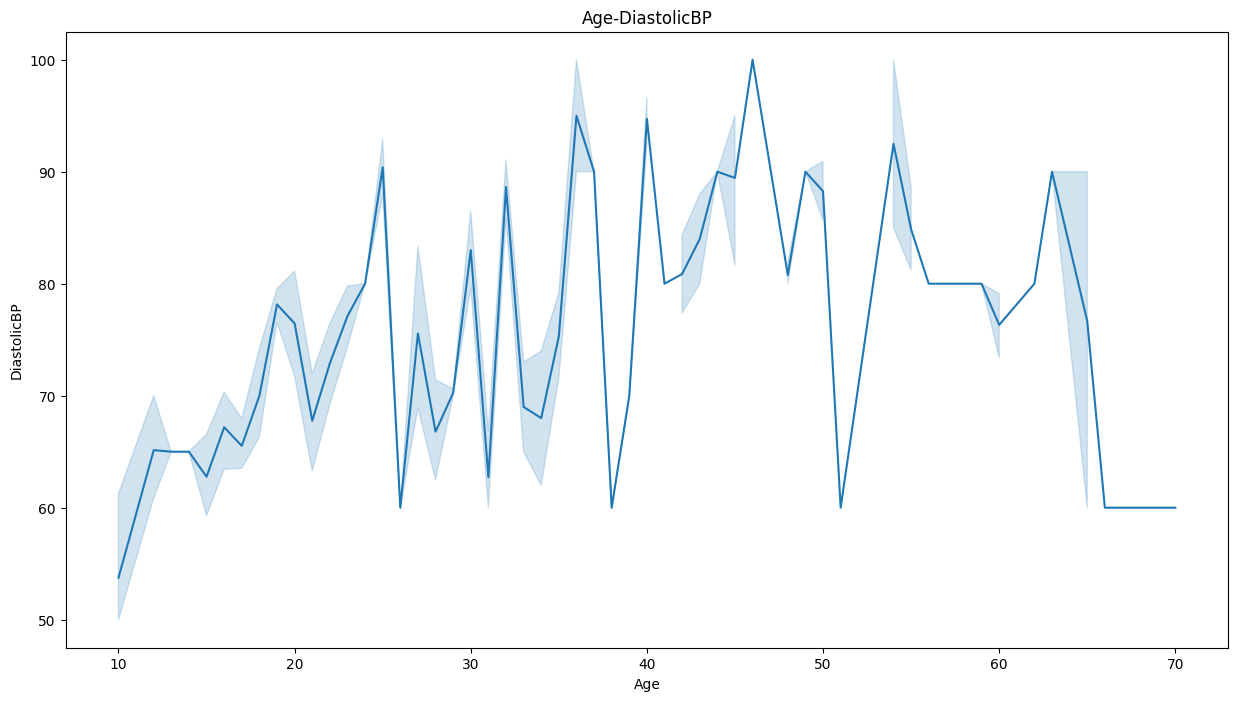

In [25]:
# SystolicBP'nin yaşa göre grafiğini çizdirelim
plt.figure(figsize=(15,8))
sns.lineplot(data=data, x="Age", y="DiastolicBP")
plt.xlabel('Age')
plt.ylabel('DiastolicBP')
plt.title('Age-DiastolicBP')
plt.show()

In [26]:
# burada DiastolicBP'nin kalp hızına bir etkisi olup olmadığını test edelim
from scipy.stats import pearsonr

corr, p = pearsonr(data['DiastolicBP'], data['HeartRate'])

print(corr, p)

if p <= 0.05:
    print("İlişki vardır (H0 reddedilir)")
else: 
    print("İlişki yoktur (H0 reddedilemez)")

-0.04615057091697696 0.14195233069036556
İlişki yoktur (H0 reddedilemez)


In [27]:
relationTests(data=data, numericalData="DiastolicBP", categoricalData="RiskLevel")

c:\Users\Diablo\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_stats_py.py:4133: DegenerateDataWarning: at least one input has length 0
  warnings.warn(stats.DegenerateDataWarning('at least one input '


False

In [28]:
data["BS"].describe()

count    1014.000000
mean        8.725986
std         3.293532
min         6.000000
25%         6.900000
50%         7.500000
75%         8.000000
max        19.000000
Name: BS, dtype: float64

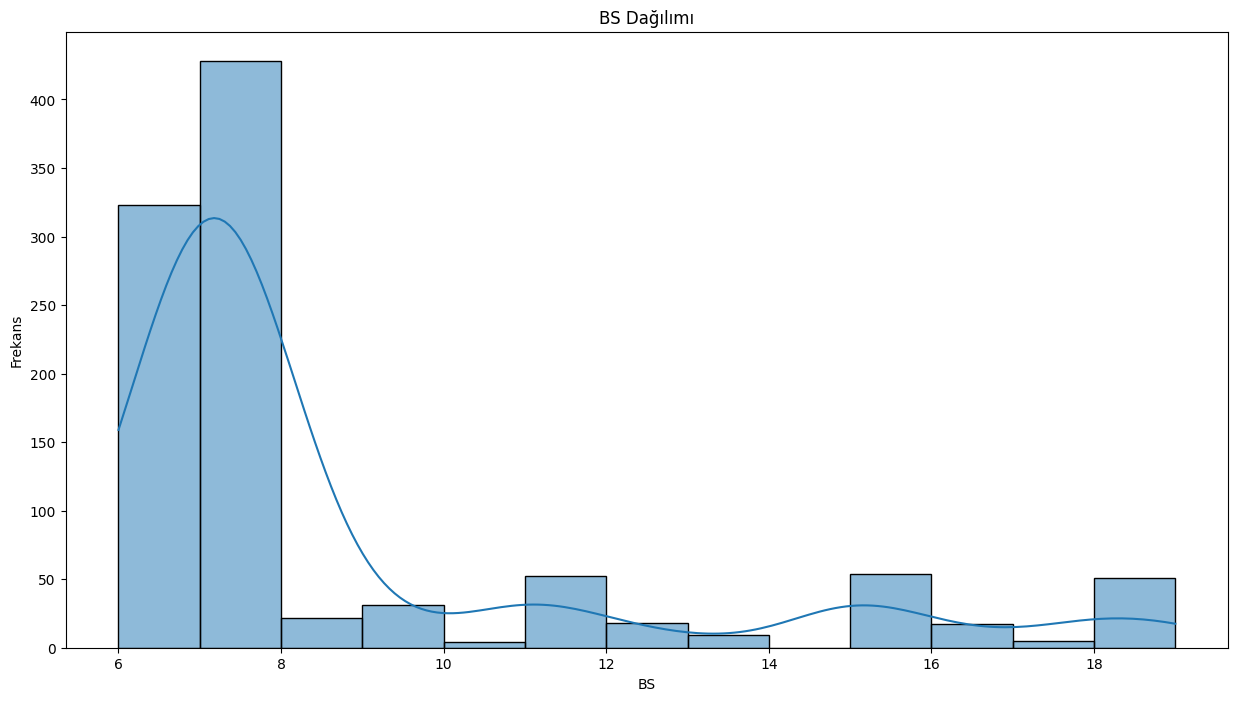

In [29]:
# burada verimizde ki BS değerinin histogramını ve dağılım grafiğini çizdirelim
plt.figure(figsize=(15,8))
sns.histplot(data['BS'], bins=13, kde=True)
plt.xlabel('BS')
plt.ylabel('Frekans')
plt.title('BS Dağılımı')
plt.show()

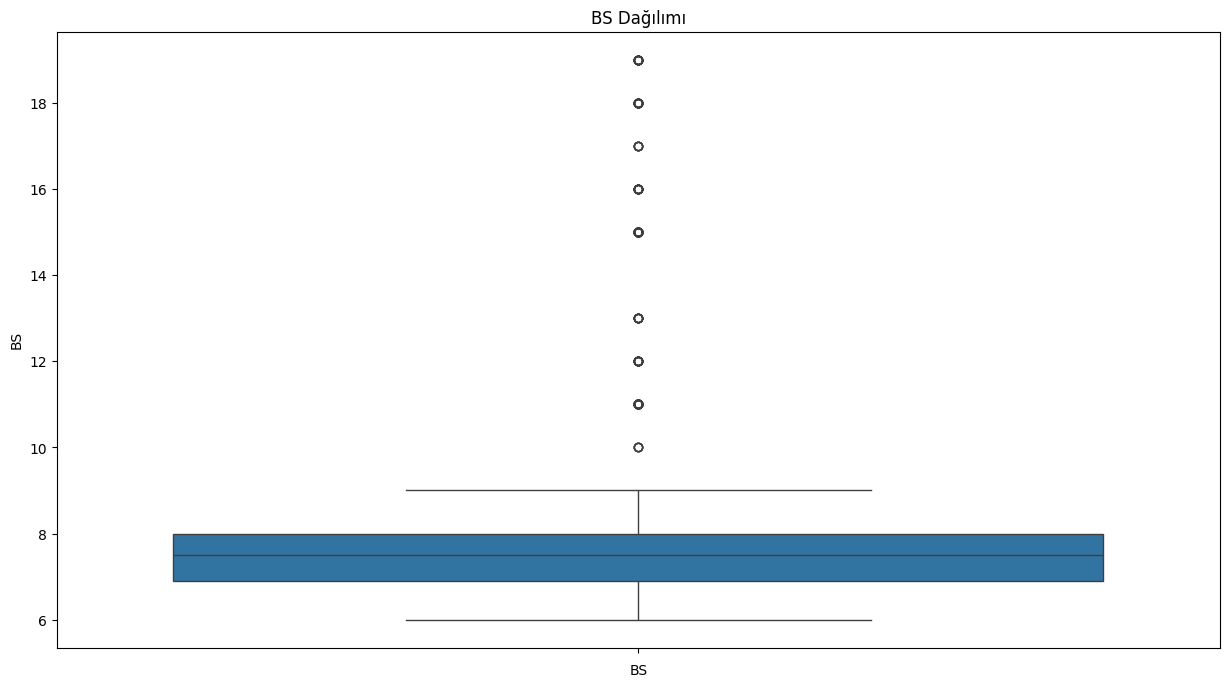

In [30]:
# brauda da BS değişkenimizin boxplotını çizdirelim
plt.figure(figsize=(15,8))
sns.boxplot(y=data["BS"])
plt.xlabel('BS')
plt.title('BS Dağılımı')
plt.show()


In [31]:
data["BS"].value_counts().sum()

1014

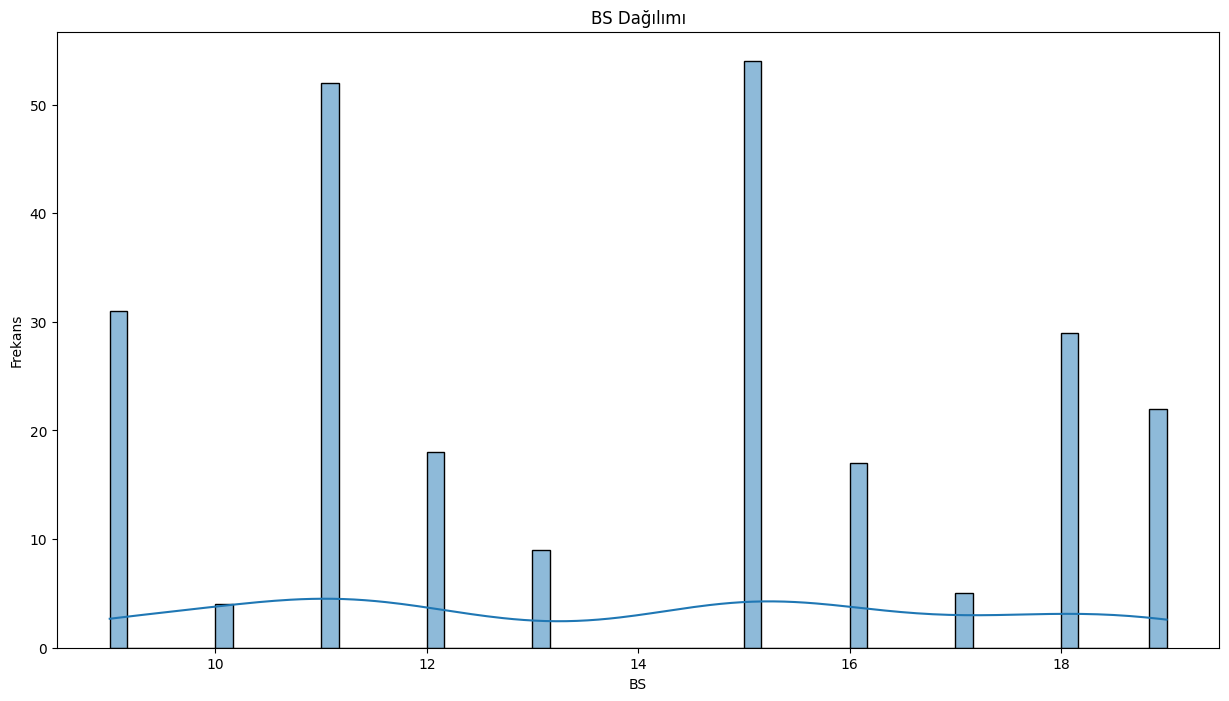

In [32]:
# buarda da BS değişkenimizde ki %75'inden büyük değerleri alıyoruz
q3 = data["BS"].quantile(0.75)

#q3 değerinden büyük olanları çekiyoruz ve yaş dağılımını inceliyoruz ve grafiğe döküyoruz
plt.figure(figsize=(15,8))
sns.histplot(data[data["BS"]>q3]['BS'], bins=60, kde=True)
plt.xlabel('BS')
plt.ylabel('Frekans')
plt.title('BS Dağılımı')
plt.show()

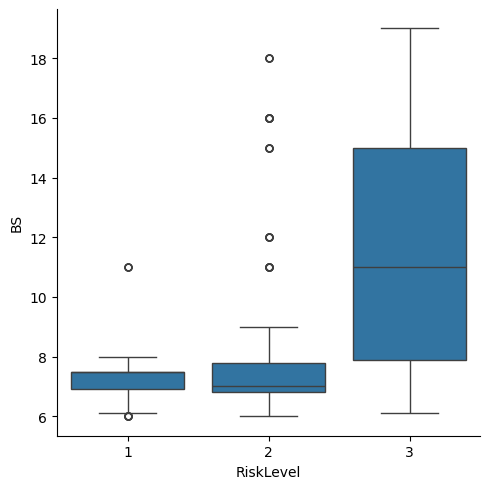

In [33]:
sns.catplot(data=data, x="RiskLevel", y="BS", kind="box")

In [34]:
relationTests(data=data, numericalData="BS", categoricalData="RiskLevel")

c:\Users\Diablo\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_stats_py.py:4133: DegenerateDataWarning: at least one input has length 0
  warnings.warn(stats.DegenerateDataWarning('at least one input '


False

In [35]:
data.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,3
1,35,140,90,13.0,98.0,70,3
2,29,90,70,8.0,100.0,80,3
3,30,140,85,7.0,98.0,70,3
4,35,120,60,6.1,98.0,76,1


In [36]:
# bodyTemp

In [37]:
data["BodyTemp"].describe()

count    1014.000000
mean       98.665089
std         1.371384
min        98.000000
25%        98.000000
50%        98.000000
75%        98.000000
max       103.000000
Name: BodyTemp, dtype: float64

In [38]:
data["BodyTemp"].value_counts()

BodyTemp
98.0     804
101.0     98
102.0     66
100.0     20
103.0     13
99.0      10
98.4       2
98.6       1
Name: count, dtype: int64

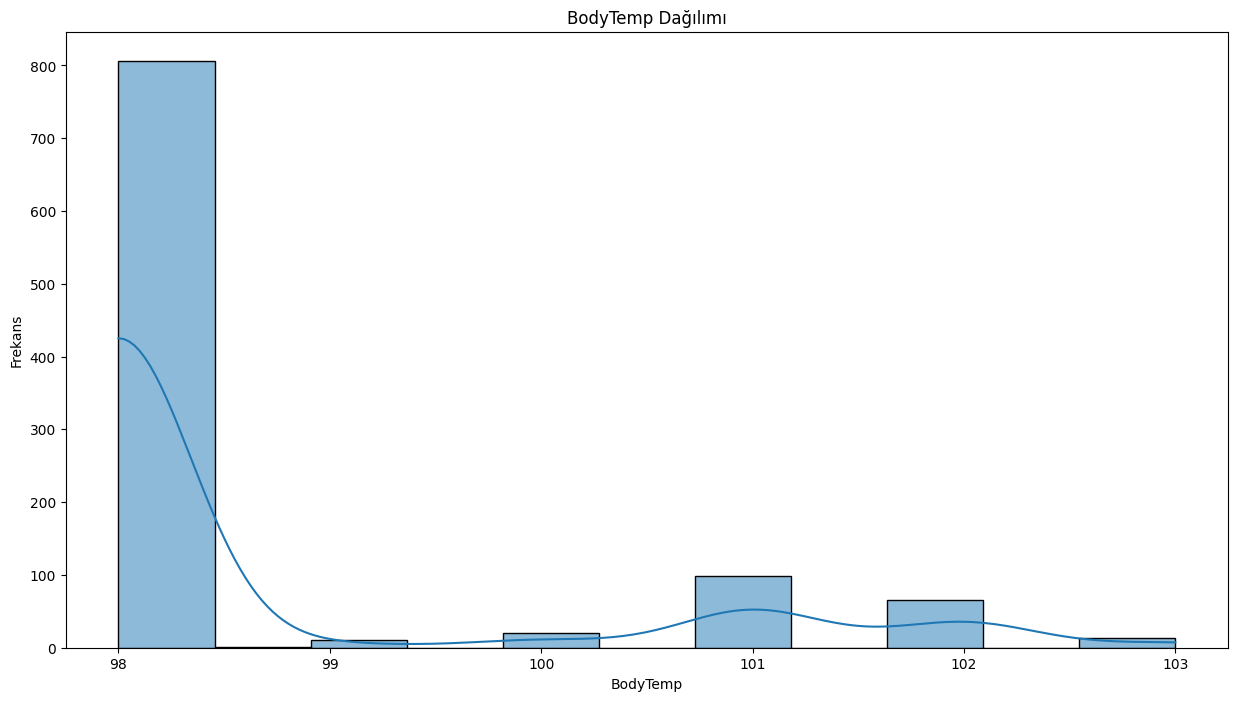

In [39]:
# BodyTemp verimizin histogramını çizdirelim
plt.figure(figsize=(15,8))
sns.histplot(data['BodyTemp'], kde=True)
plt.xlabel('BodyTemp')
plt.ylabel('Frekans')
plt.title('BodyTemp Dağılımı')
plt.show()

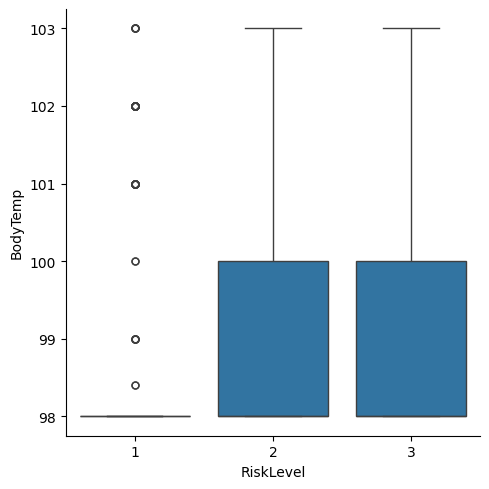

In [40]:
# burada da BodyTemp değişkenimizin RiskLevel'a göre boxplotını çizdirelim
sns.catplot(data=data, x="RiskLevel", y="BodyTemp", kind="box")


In [42]:
relationTests(data=data, numericalData="BS", categoricalData="RiskLevel")

c:\Users\Diablo\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_stats_py.py:4133: DegenerateDataWarning: at least one input has length 0
  warnings.warn(stats.DegenerateDataWarning('at least one input '


False

In [43]:
data.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,3
1,35,140,90,13.0,98.0,70,3
2,29,90,70,8.0,100.0,80,3
3,30,140,85,7.0,98.0,70,3
4,35,120,60,6.1,98.0,76,1


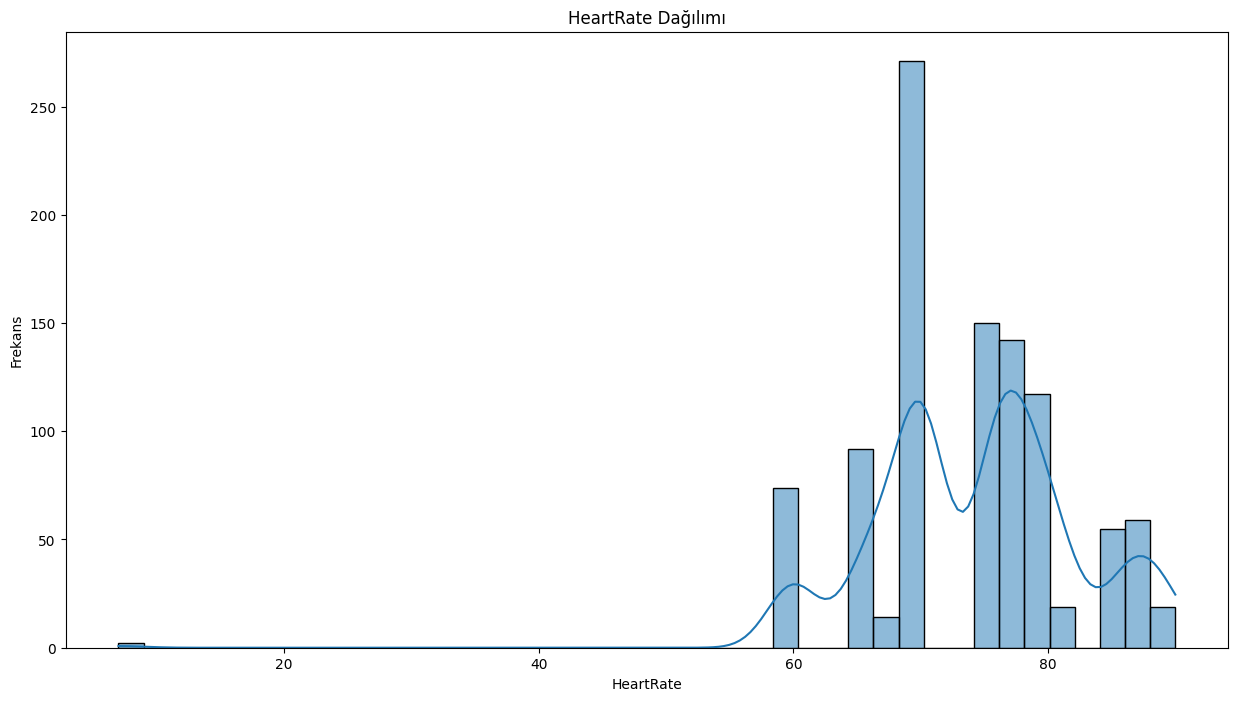

In [44]:
# HeartRate verimizin histogramını çizdirelim
plt.figure(figsize=(15,8))
sns.histplot(data['HeartRate'], kde=True)
plt.xlabel('HeartRate')
plt.ylabel('Frekans')
plt.title('HeartRate Dağılımı')
plt.show()

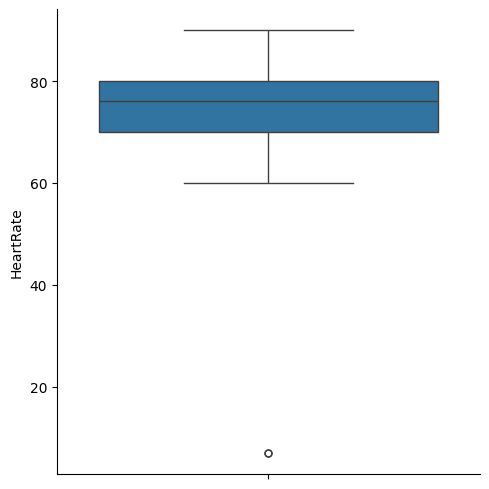

In [45]:
# burada da HeartRate değişkenimizin boxplotını çizdirelim
sns.catplot(data=data, y="HeartRate", kind="box")


In [48]:
relationTests(data=data, numericalData="BS", categoricalData="RiskLevel")

c:\Users\Diablo\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_stats_py.py:4133: DegenerateDataWarning: at least one input has length 0
  warnings.warn(stats.DegenerateDataWarning('at least one input '


False

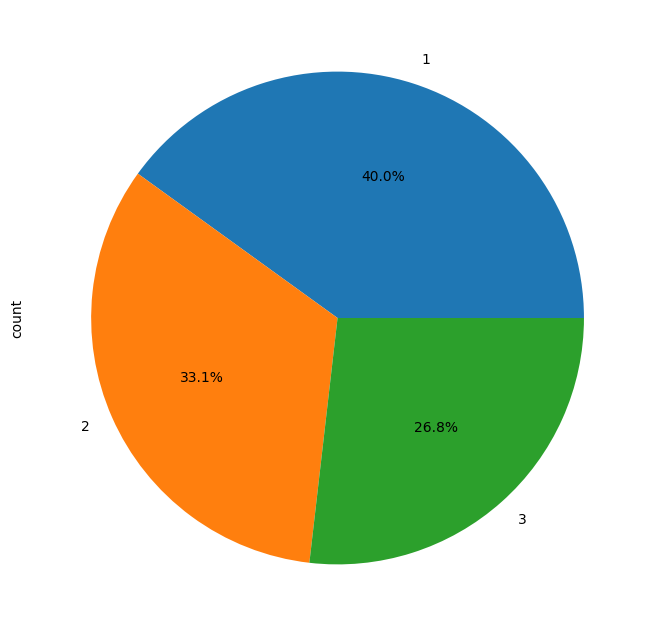

In [49]:
# burada da riskLevelimizin pasta grafiğini çizdiriyoruz
plt.figure(figsize=(15,8))
data["RiskLevel"].value_counts().plot.pie(autopct="%1.1f%%")
plt.show()


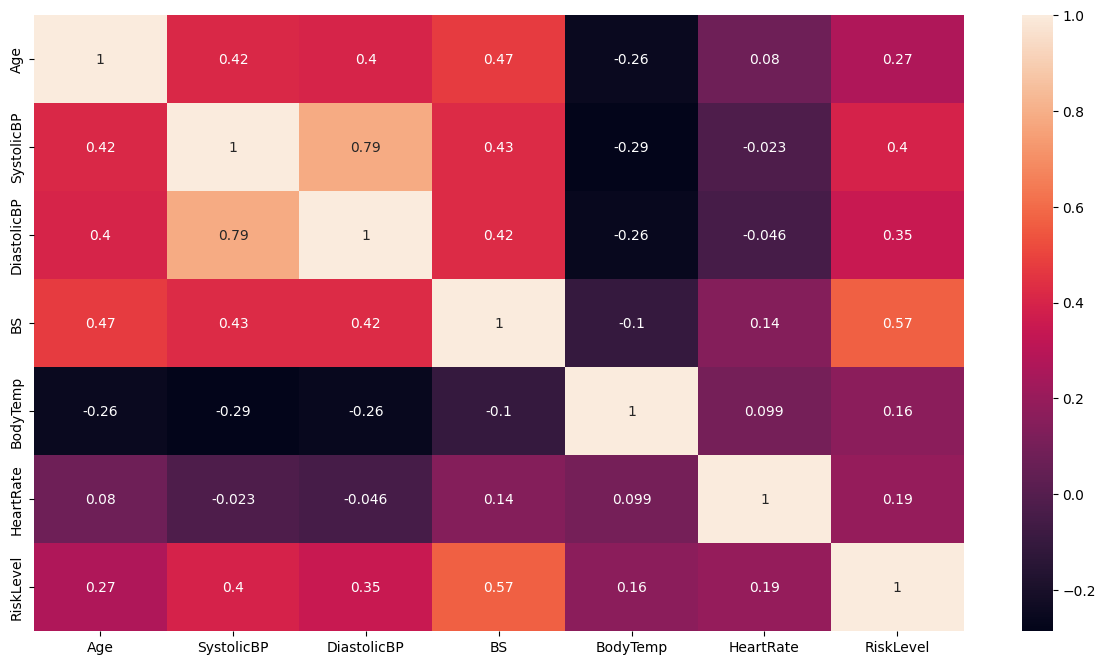

In [50]:
# bağımsız değişkenlerimizin korelasyon matrisini çizdirelim
corr = data.corr()
plt.figure(figsize=(15,8))
sns.heatmap(corr, annot=True)
plt.show()


In [51]:
# KARAR AĞAÇLARI

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# bağımlı ve bağımsız değişkenlerimizi ayırıyoruz
X = data.drop('RiskLevel', axis=1)
y = data['RiskLevel']

# verimizi train ve test olarak ayırıyoruz
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# modelimizi oluşturuyoruz
tree = DecisionTreeClassifier()

# modelimizi eğitiyoruz
tree.fit(X_train, y_train)

DecisionTreeClassifier()

In [53]:
# modelimiz ile tahmin yapıyoruz
y_pred = tree.predict(X_test)

In [54]:
print("Eğitim setindeki doğruluk oranı: {:.3f}".format(tree.score(X_train, y_train)))
print("Test setindeki doğruluk oranı: {:.3f}".format(tree.score(X_test, y_test)))

Eğitim setindeki doğruluk oranı: 0.936
Test setindeki doğruluk oranı: 0.808


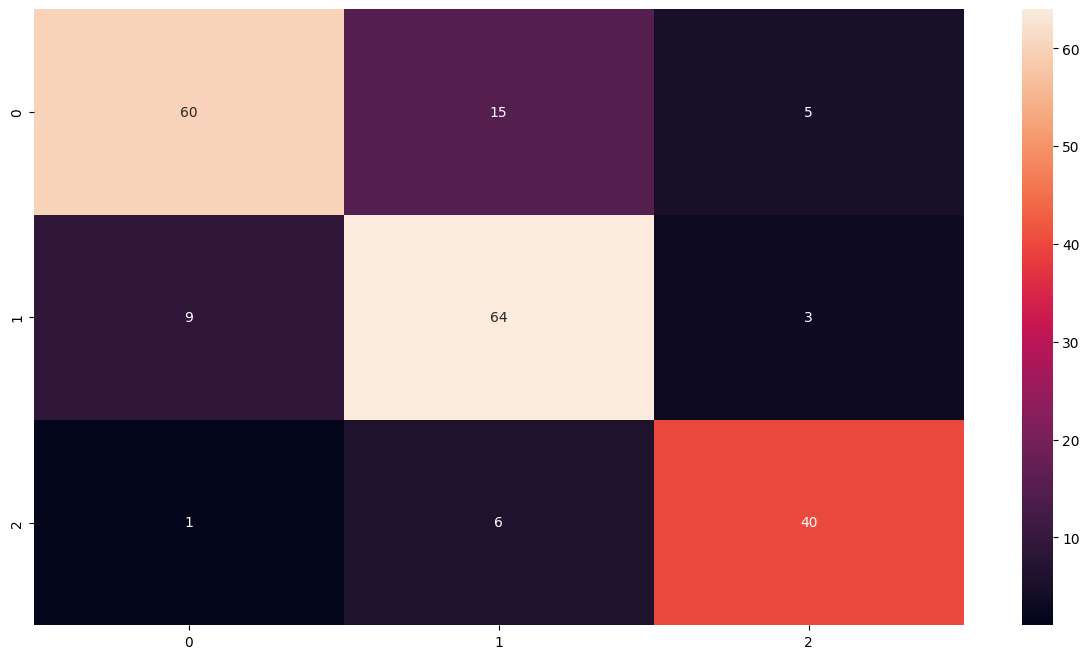

In [55]:
# confusion matrix çizdiriyoruz
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(15,8))
sns.heatmap(cm, annot=True)
plt.show()

In [56]:
# burada skorumuzu çizdiriyoruz
print(classification_report(y_test, y_pred)) 

              precision    recall  f1-score   support

           1       0.86      0.75      0.80        80
           2       0.75      0.84      0.80        76
           3       0.83      0.85      0.84        47

    accuracy                           0.81       203
   macro avg       0.81      0.81      0.81       203
weighted avg       0.81      0.81      0.81       203



In [57]:
# burada her özelliğin önemini ve ismini yazdırıoyurz
for feature in zip(data.columns, tree.feature_importances_):
    print(feature)
    

('Age', 0.14446623801035122)
('SystolicBP', 0.19509232916155225)
('DiastolicBP', 0.07166648025998523)
('BS', 0.42592939794118734)
('BodyTemp', 0.07253509317400751)
('HeartRate', 0.09031046145291624)


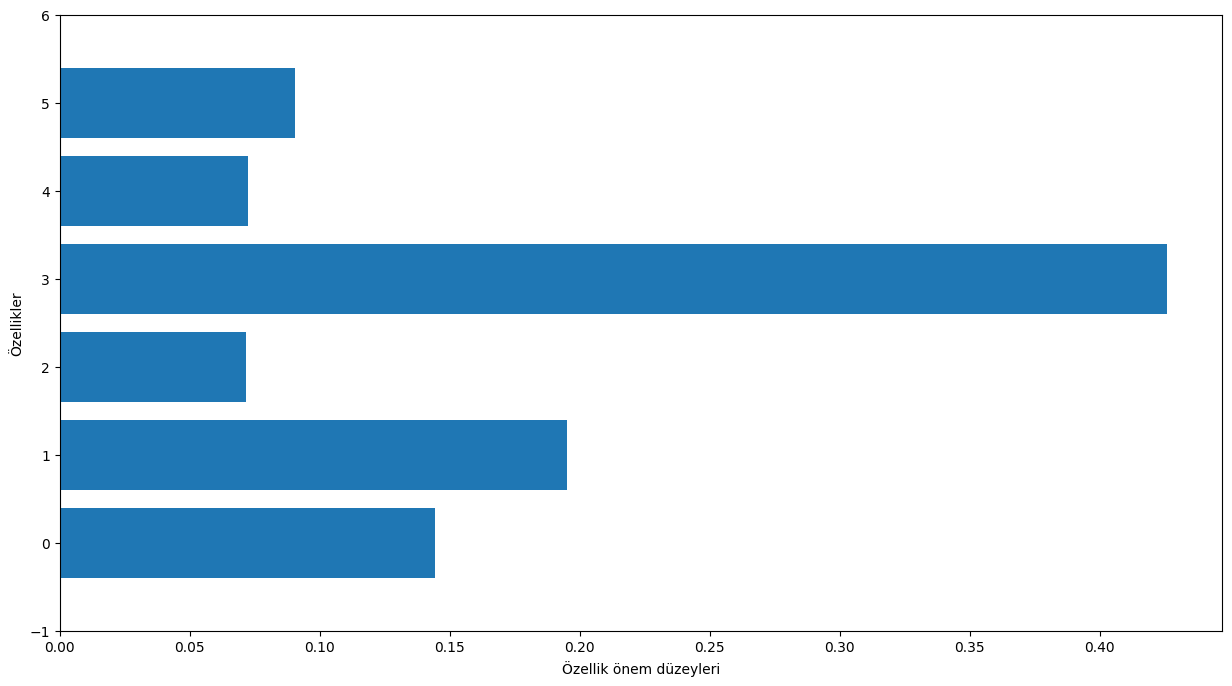

In [58]:
def plot_feature_importances(model):
    plt.figure(figsize=(15,8))
    n_features = 6
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.xlabel("Özellik önem düzeyleri")
    plt.ylabel("Özellikler")
    plt.ylim(-1, n_features)
    
plot_feature_importances(tree)